In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from findiff import FinDiff, Identity, PDE, BoundaryConditions
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
os.chdir("/home/so/Documents/Projects/NeuralInterpolation")
from models.siren import Siren

Generate a synthetic Gaussian random field by solving the SPDE
\begin{align}
(\kappa^2 - \Delta) f = \mathcal{W}.
\end{align}

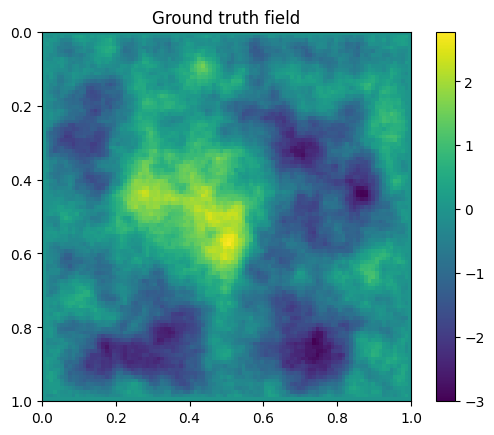

In [2]:
d = 2
ls = 0.15
nu = 1
amp = 1.1
kappa = np.sqrt(2*nu) / ls
q = ((4*np.pi)**(d/2)*kappa**(2*nu)*gamma(nu+d/2))/gamma(nu)
grid_size = 100

x = y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y, indexing='ij')
X_test = np.stack([X.flatten(), Y.flatten()], axis=1)

shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
diff_op = kappa**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
np.random.seed(0)
W = (1/np.sqrt(dx*dy)) * np.sqrt(q) * amp * np.random.randn(*shape)

# Set boundary conditions (zero-Dirichlet)
bc = BoundaryConditions(shape)
bc[0, :] = 0
bc[-1,:] = 0
bc[:, 0] = 0
bc[:, -1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.colorbar()
plt.title('Ground truth field')
plt.show()

Sample random points for observation

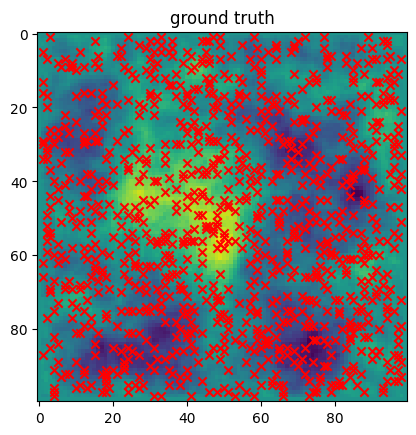

In [3]:
num_obs = 1000
obs_noise = 0

# Get observations at random locations
rng = np.random.default_rng(0)
x_idxs = y_idxs = np.arange(grid_size)
X_idxs, Y_idxs = np.meshgrid(x_idxs[1:-1], y_idxs[1:-1], indexing='ij')
all_idxs = np.stack([X_idxs.flatten(), Y_idxs.flatten()], axis=1)
idxs = rng.choice(all_idxs, num_obs, replace=False)
obs_dict = {tuple(idx): u[tuple(idx)]+obs_noise*np.random.randn() for idx in idxs}

# Plot results
plt.imshow(u)
plt.title('ground truth')
plt.scatter(idxs[:,1], idxs[:,0], c='r', marker='x')

In [4]:
# Create pytorch dataloader
X = list(obs_dict.keys())
Y = list(obs_dict.values())
X = np.array(X)
Y = np.array(Y)
tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(Y)

my_dataset = TensorDataset(tensor_x/100, tensor_y[:,None]) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=256, shuffle=True) # create your dataloader

In [5]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)

img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [6]:
num_epochs = 200
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

for epoch in range(num_epochs):
    epoch_loss = 0
    N = 0
    for i, data in enumerate(my_dataloader):
      model_input, ground_truth = data
      model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
      model_output, coords = img_siren(model_input)    
      loss = ((model_output - ground_truth)**2).mean()
      bs = model_input.shape[0]
      N += bs
      epoch_loss += loss * bs
      optim.zero_grad()
      loss.backward()
      optim.step()
    epoch_loss /= N
    print(f"Epoch {epoch}: loss {epoch_loss}")

Epoch 0: loss 0.900577962398529
Epoch 1: loss 0.5667322278022766
Epoch 2: loss 0.4133078157901764
Epoch 3: loss 0.33059823513031006
Epoch 4: loss 0.26216670870780945
Epoch 5: loss 0.21137867867946625
Epoch 6: loss 0.17152918875217438
Epoch 7: loss 0.13891932368278503
Epoch 8: loss 0.11450492590665817
Epoch 9: loss 0.09597516059875488
Epoch 10: loss 0.07908721268177032
Epoch 11: loss 0.06804219633340836
Epoch 12: loss 0.05882244557142258
Epoch 13: loss 0.052552480250597
Epoch 14: loss 0.046522945165634155
Epoch 15: loss 0.04089515656232834
Epoch 16: loss 0.036890625953674316
Epoch 17: loss 0.03507351130247116
Epoch 18: loss 0.032814107835292816
Epoch 19: loss 0.031138509511947632
Epoch 20: loss 0.028589608147740364
Epoch 21: loss 0.025889858603477478
Epoch 22: loss 0.02429906465113163
Epoch 23: loss 0.02252534218132496
Epoch 24: loss 0.020539650693535805
Epoch 25: loss 0.018829088658094406
Epoch 26: loss 0.017895320430397987
Epoch 27: loss 0.017201295122504234
Epoch 28: loss 0.015689825

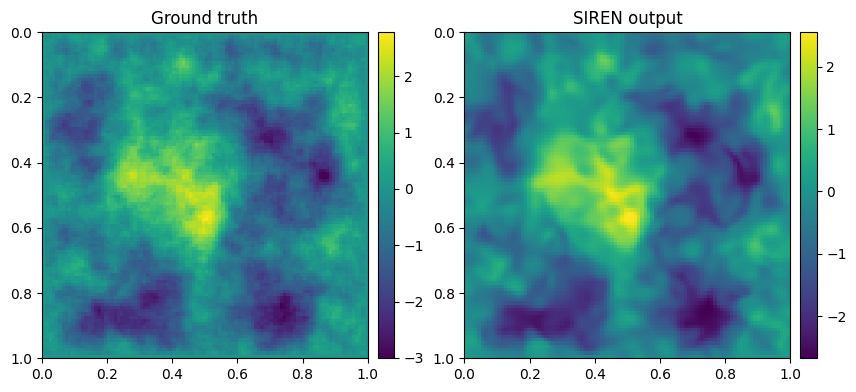

In [7]:
X_test = torch.Tensor(all_idxs).cuda()
model_output, coords = img_siren(X_test/100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

divider1 = make_axes_locatable(ax1)
im1 = ax1.imshow(u, extent=[0,1,1,0])
ax1.set_title('Ground truth')
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1, cax=cax1, orientation='vertical')

divider2 = make_axes_locatable(ax2)
im2 = ax2.imshow(model_output.reshape(98,98).cpu().detach().numpy(), extent=[0,1,1,0])
ax2.set_title('SIREN output')
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2, cax=cax2, orientation='vertical')